Systemic Velocity
============================

Setup
-----------------------------

Let's first make sure we have the latest version of PHOEBE 2.3 installed (uncomment this line if running in an online notebook session such as colab).

In [1]:
#!pip install -I "phoebe>=2.3,<2.4"

As always, let's do imports and initialize a logger and a new Bundle.

In [2]:
import phoebe
from phoebe import u # units
import numpy as np
import matplotlib.pyplot as plt

logger = phoebe.logger()

b = phoebe.default_binary()

Now we'll create empty lc, rv, orb, and mesh datasets.  We'll then look to see how the systemic velocity (vgamma) affects the observables in each of these datasets, and how those are also affected by light-time effects (ltte).

To see the effects over long times, we'll compute one cycle starting at t=0, and another in the distant future.

In [3]:
times1 = np.linspace(0,1,201)
times2 = np.linspace(90,91,201)

In [4]:
b.add_dataset('lc', times=times1, dataset='lc1')
b.add_dataset('lc', times=times2, dataset='lc2')

<ParameterSet: 43 parameters | contexts: dataset, figure, compute, constraint>

In [5]:
b.add_dataset('rv', times=times1, dataset='rv1')
b.add_dataset('rv', times=times2, dataset='rv2')

<ParameterSet: 45 parameters | contexts: dataset, figure, compute, constraint>

In [6]:
b.add_dataset('orb', times=times1, dataset='orb1')
b.add_dataset('orb', times=times2, dataset='orb2')

Thu, 17 Sep 2020 11:19 BUNDLE       WARNING orb dataset uses 'compute_times' instead of 'times', applying value sent as 'times' to 'compute_times'.
Thu, 17 Sep 2020 11:19 BUNDLE       WARNING orb dataset uses 'compute_times' instead of 'times', applying value sent as 'times' to 'compute_times'.


<ParameterSet: 9 parameters | contexts: dataset, figure, compute, constraint>

In [7]:
b.add_dataset('mesh', times=[0], dataset='mesh1', columns=['vws'])
b.add_dataset('mesh', times=[90], dataset='mesh2', columns=['vws'])

Thu, 17 Sep 2020 11:19 BUNDLE       WARNING mesh dataset uses 'compute_times' instead of 'times', applying value sent as 'times' to 'compute_times'.
Thu, 17 Sep 2020 11:19 BUNDLE       WARNING mesh dataset uses 'compute_times' instead of 'times', applying value sent as 'times' to 'compute_times'.


<ParameterSet: 8 parameters | contexts: dataset, compute, constraint>

Changing Systemic Velocity and LTTE
------------------------------------------------

By default, vgamma is initially set to 0.0

In [8]:
b['vgamma@system']

<Parameter: vgamma=0.0 km / s | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>

We'll leave it set at 0.0 for now, and then change vgamma to see how that affects the observables.

The other relevant parameter here is t0 - that is the time at which all quantities are provided, the time at which nbody integration would start (if applicable), and the time at which the center-of-mass of the system is defined to be at (0,0,0).  Unless you have a reason to do otherwise, it makes sense to have this value near the start of your time data... so if we don't have any other changing quantities defined in our system and are using BJDs, we would want to set this to be non-zero.  In this case, our times all start at 0, so we'll leave t0 at 0 as well.

In [9]:
b['t0@system']

<Parameter: t0=0.0 d | keys: description, value, quantity, default_unit, limits, visible_if, copy_for, readonly, advanced, latexfmt>

The option to enable or disable LTTE are in the compute options, we can either set ltte or we can just temporarily pass a value when we call run_compute.

In [10]:
b['ltte@compute']

<Parameter: ltte=False | keys: description, value, visible_if, copy_for, readonly, advanced, latexfmt>

Let's first compute the model with 0 systemic velocity and ltte=False (not that it would matter in this case).  Let's also name the model so we can keep track of what settings were used.

In [11]:
b.run_compute(irrad_method='none', model='0_false')

100%|██████████| 402/402 [00:05<00:00, 70.19it/s]


<ParameterSet: 65 parameters | kinds: lc, rv, mesh, orb>

For our second model, we'll set a somewhat ridiculous value for the systemic velocity (so that the affects are exagerated and clearly visible over one orbit), but leave ltte off.

In [12]:
b['vgamma@system'] = 100

In [13]:
b.run_compute(irrad_method='none', model='100_false')

100%|██████████| 402/402 [00:06<00:00, 62.65it/s]


<ParameterSet: 65 parameters | kinds: lc, rv, mesh, orb>

Lastly, let's leave this value of vgamma, but enable light-time effects.

In [14]:
b.run_compute(irrad_method='none', ltte=True, model='100_true')

100%|██████████| 402/402 [00:06<00:00, 59.69it/s]


<ParameterSet: 65 parameters | kinds: lc, rv, mesh, orb>

Influence on Light Curves (fluxes)
-------------------------------------------

Now let's compare the various models across all our different datasets.

Let's set the colors so that all figures will have systemic velocity shown in blue, systemic velocity with ltte=False in red, and systemic velocity with ltte=True in green.


In [15]:
colors = {'0_false': 'b', '100_false': 'r', '100_true': 'g'}

In each of the figures below, the first panel will be the first cycle (days 0-3) and the second panel will be 100 cycles later (days 900-903).

Without light-time effects, the light curve remains unchanged by the introduction of a systemic velocity (blue and red overlap each other).   However, once ltte is enabled, the time between two eclipses (ie the observed period of the system) changes.  This occurs because the path between the system and observer has changed.  This is an important effect to note - the period parameter sets the TRUE period of the system, not necessarily the observed period between two successive eclipses. 

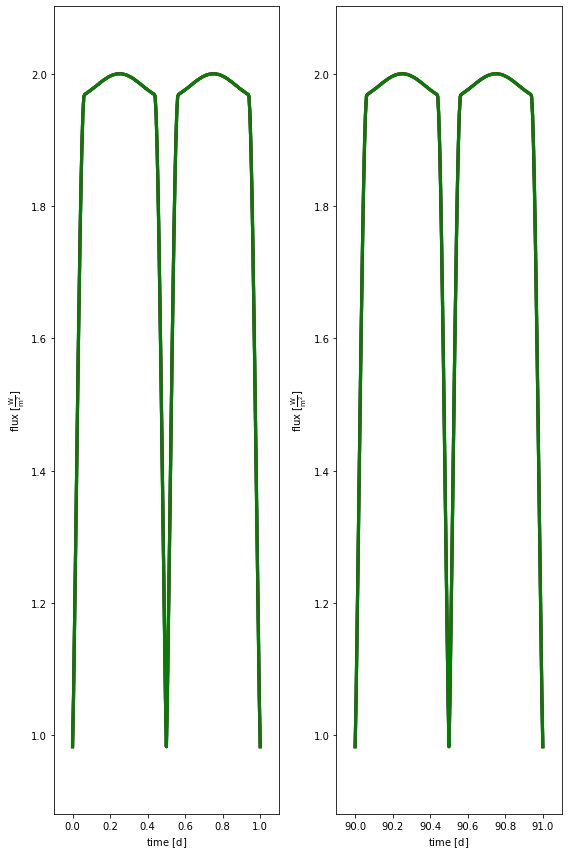

In [16]:
afig, mplfig = b['lc'].plot(c=colors, linestyle='solid', 
                            axorder={'lc1': 0, 'lc2': 1}, 
                            subplot_grid=(1,2), tight_layout=True, show=True)

Influence on Radial Velocities
------------------------------------

Radial velocities are perhaps the most logical observable in the case of systemic velocities.  Introducing a non-zero value for vgamma simply offsets the observed values.

Light-time will have a similar affect on RVs as it does on LCs - it simply changes the observed period.

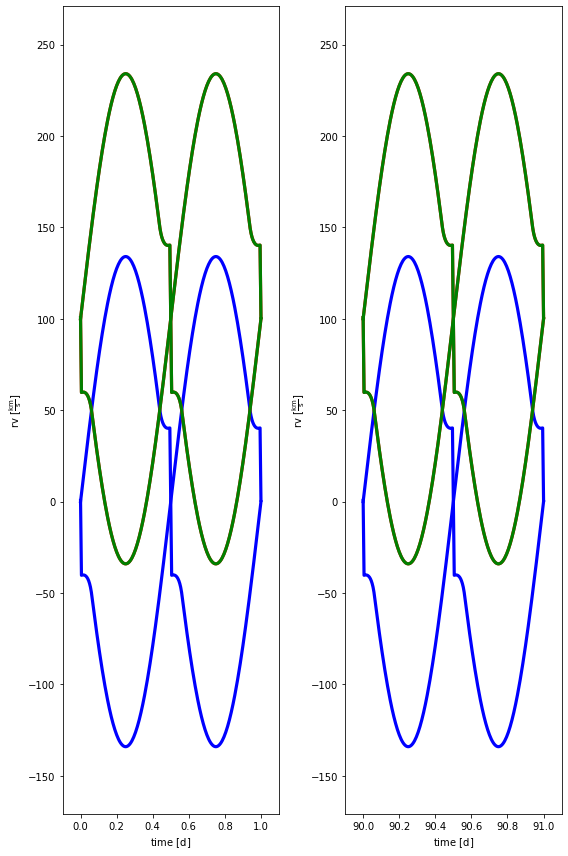

In [17]:
afig, mplfig = b['rv'].plot(c=colors, linestyle='solid', 
                            axorder={'rv1': 0, 'rv2': 1}, 
                            subplot_grid=(1,2), tight_layout=True, show=True)

Influence on Orbits (positions, velocities)
----------------------

In the orbit, the addition of a systemic velocity affects both the positions and velocities.  So if we plot the orbits from above (u-w plane) we can see see orbit spiral in the w-direction.  Note that this actually shows the barycenter of the orbit moving - and it was only at 0,0,0 at t0.  This also stresses the importance of using a reasonable t0 - here 900 days later, the barycenter has moved significantly from the center of the coordinate system.

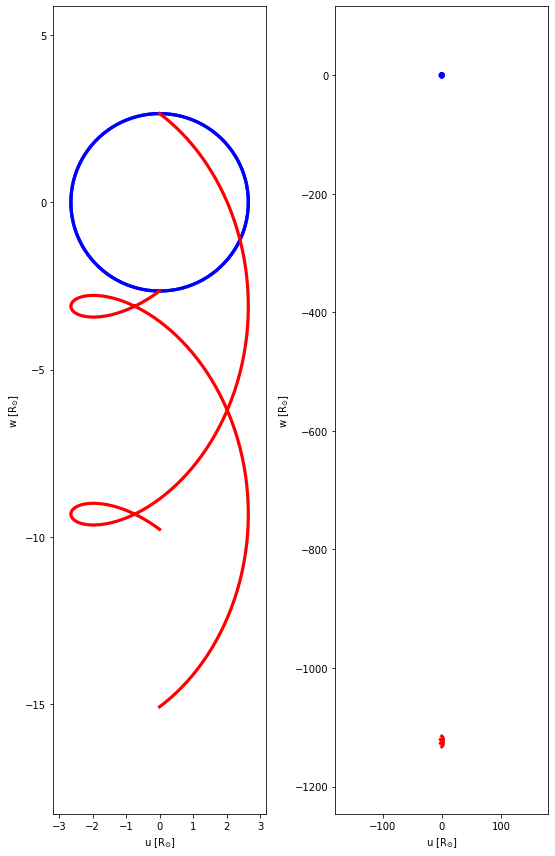

In [18]:
afig, mplfig = b.filter(kind='orb', model=['0_false', '100_false']).plot(x='us', y='ws', 
                             c=colors, linestyle='solid', 
                             axorder={'orb1': 0, 'orb2': 1}, 
                             subplot_grid=(1,2), tight_layout=True, show=True)

Plotting the w-velocities with respect to time would show the same as the RVs, except without any Rossiter-McLaughlin like effects.  Note however the flip in w-convention between vw and radial velocities (+w is defined as towards the observer to make a right-handed system, but by convention +rv is a red shift).

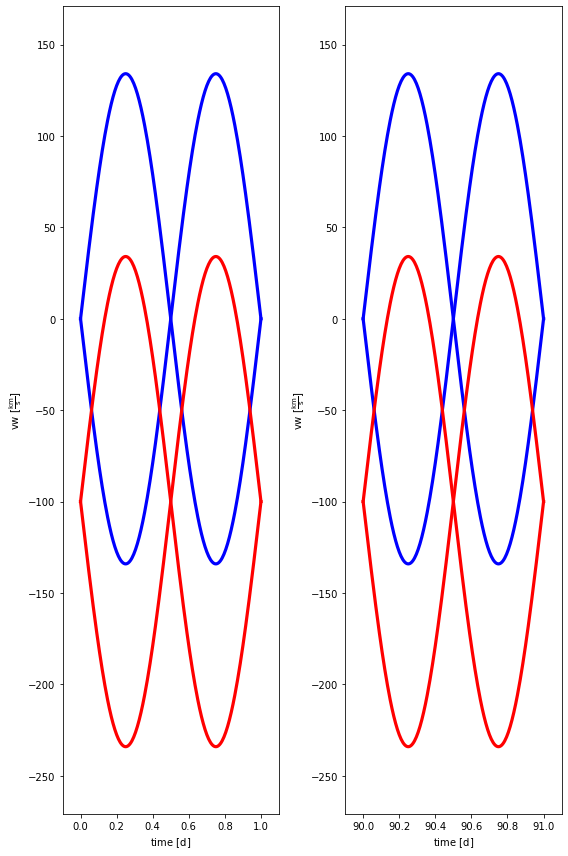

In [19]:
afig, mplfig = b.filter(kind='orb', model=['0_false', '100_false']).plot(x='times', y='vws',
                             c=colors, linestyle='solid', 
                             axorder={'orb1': 0, 'orb2': 1}, 
                             subplot_grid=(1,2), tight_layout=True, show=True)

Now let's look at the effect that enabling ltte has on these same plots.

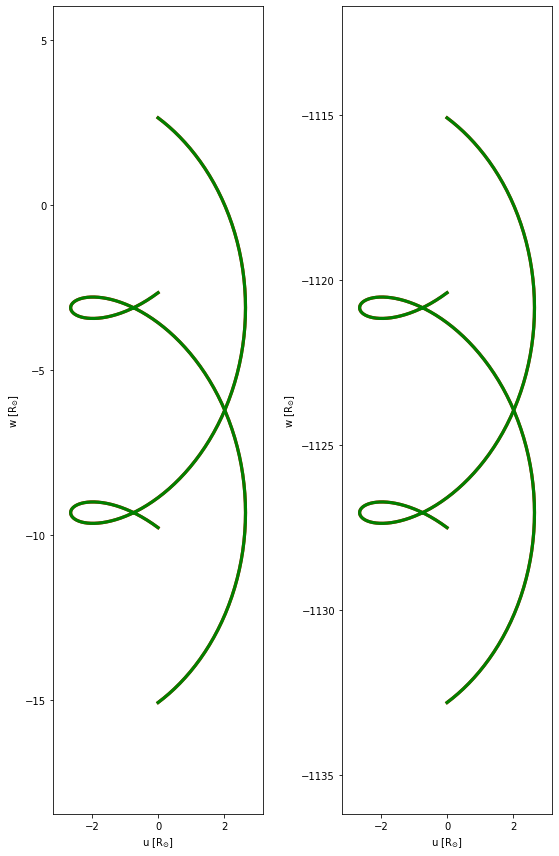

In [20]:
afig, mplfig = b.filter(kind='orb', model=['100_false', '100_true']).plot(x='us', y='ws', 
                             c=colors, linestyle='solid', 
                             axorder={'orb1': 0, 'orb2': 1}, 
                             subplot_grid=(1,2), tight_layout=True, show=True)

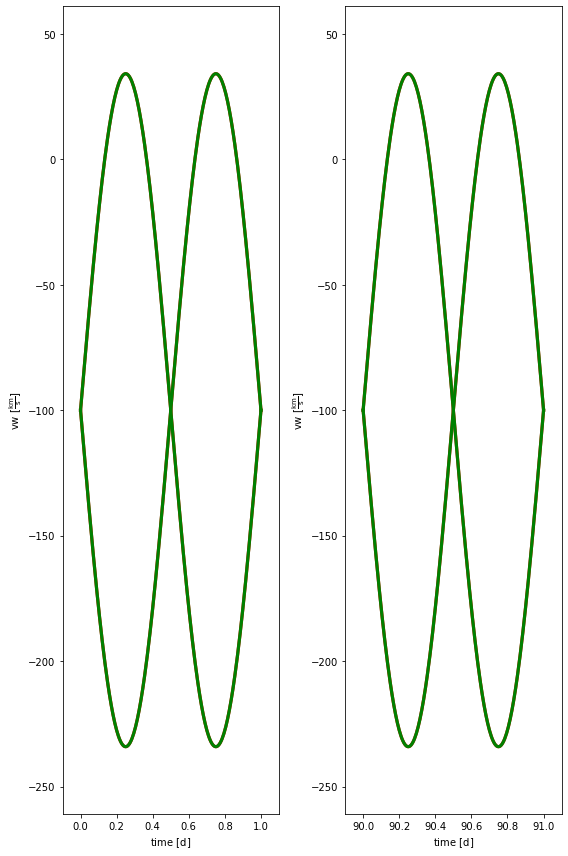

In [21]:
afig, mplfig = b.filter(kind='orb', model=['100_false', '100_true']).plot(x='times', y='vws',
                             c=colors, linestyle='solid', 
                             axorder={'orb1': 0, 'orb2': 1}, 
                             subplot_grid=(1,2), tight_layout=True, show=True)

Influence on Meshes
--------------------------

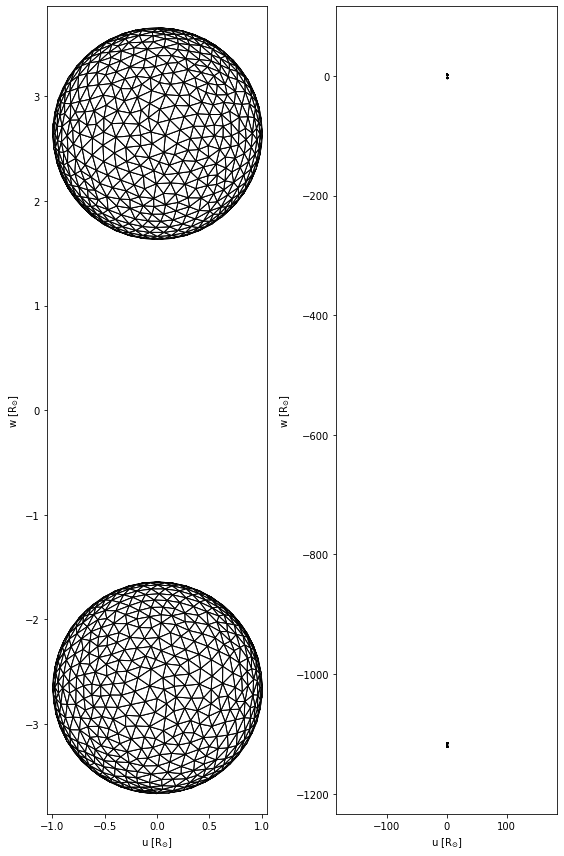

In [22]:
afig, mplfig = b.filter(kind='mesh', model=['0_false', '100_false']).plot(x='us', y='ws',
                                                                          axorder={'mesh1': 0, 'mesh2': 1},
                                                                          subplot_grid=(1,2), tight_layout=True, show=True)

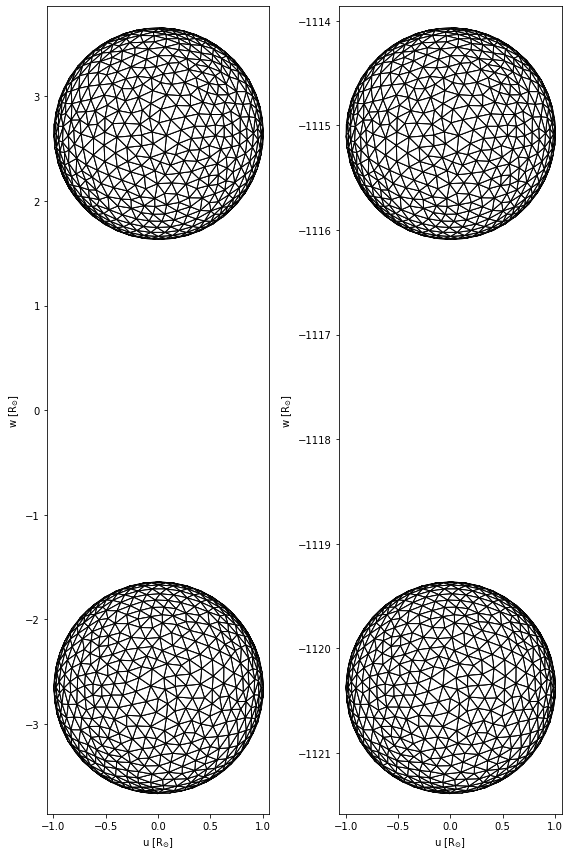

In [23]:
afig, mplfig = b.filter(kind='mesh', model=['100_false', '100_true']).plot(x='us', y='ws',
                                                                          axorder={'mesh1': 0, 'mesh2': 1},
                                                                          subplot_grid=(1,2), tight_layout=True, show=True)

As you can see, since the center of mass of the system was at 0,0,0 at t0 - including systemic velocity actually shows the system spiraling towards or away from the observer (who is in the positive w direction).  In other words - the positions of the meshes are affected in the same way as the orbits (note the offset on the ylimit scales).

In addition, the actual values of vw and rv in the meshes are adjusted to include the systemic velocity.

In [24]:
b['primary@mesh1@0_false'].get_value('vws', time=0.0)[:5]

array([ 3.51428103e+00,  1.88225026e-05, -3.51419791e+00, -3.51419148e+00,
        1.15547202e-05])

In [25]:
b['primary@mesh1@100_false'].get_value('vws', time=0.0)[:5]

array([ -96.48571897,  -99.99998118, -103.51419791, -103.51419148,
        -99.99998845])

In [26]:
b['primary@mesh1@100_true'].get_value('vws', time=0.0)[:5]

array([ -96.48571897,  -99.99998118, -103.51419791, -103.51419148,
        -99.99998845])